In [183]:
import re
import gc

In [184]:
import numpy as np,pandas as pd
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,auc
from sklearn.metrics import confusion_matrix,accuracy_score
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
import pickle
from sklearn.preprocessing import LabelEncoder

In [185]:
np.random.seed(0)

In [186]:
%%time
test=pd.read_csv('test_QoiMO9B.csv')
train=pd.read_csv('train_GzS76OK/train.csv')
center=pd.read_csv('train_GzS76OK/fulfilment_center_info.csv')
meal=pd.read_csv('train_GzS76OK/meal_info.csv')
#sub=pd.read_csv('sample_submission.csv')


CPU times: user 272 ms, sys: 3.98 ms, total: 276 ms
Wall time: 248 ms


### PREPROCESSING

In [187]:
def save_model(model,filename):
    filename = filename+'.sav'
    pickle.dump(model, open(filename, 'wb'))
    print('model saved as '+filename)


In [188]:
train.shape,center.shape,meal.shape,test.shape

((456548, 9), (77, 5), (51, 3), (32573, 8))

In [189]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [190]:
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [191]:
for i in train.columns : 
    print(i,' : ' ,train[i].nunique())

id  :  456548
week  :  145
center_id  :  77
meal_id  :  51
checkout_price  :  1992
base_price  :  1907
emailer_for_promotion  :  2
homepage_featured  :  2
num_orders  :  1250


In [192]:
train['week_num']=train.week%52
test['week_num']=test.week%52

## Validation

In [193]:
# def get_validset(train):
#     test = train[train.week>=135]
#     train=train[train.week<135]
#     return train,test

# train,test=get_validset(train)
# train.shape,test.shape


# test.num_orders=np.log1p(test.num_orders)


In [194]:
#changing target to its log value 
train.num_orders=np.log1p(train.num_orders)

In [195]:
%%time
train=pd.merge(train,center,how='left',on=['center_id'])
test=pd.merge(test,center,how='left',on=['center_id'])
train=pd.merge(train,meal,how='left',on=['meal_id'])
test=pd.merge(test,meal,how='left',on=['meal_id'])
train.shape,test.shape

CPU times: user 342 ms, sys: 16 ms, total: 358 ms
Wall time: 130 ms


In [196]:
train.center_id.nunique()

77

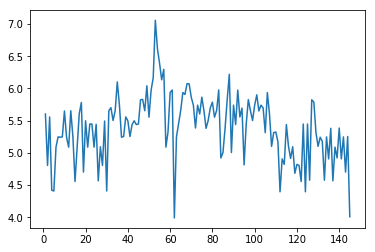

In [197]:
temp=train[(train.meal_id==1993)&(train.center_id==55)]
temp=temp.groupby(['week'])['num_orders'].sum().reset_index()

plt.plot(temp.week,temp.num_orders)

In [198]:
# train['discount_applied']=((train.base_price-train.checkout_price)>0).astype(int)
# test['discount_applied']=((test.base_price-test.checkout_price)>0).astype(int)

In [199]:
train['discount_amount']=train.base_price-train.checkout_price
test['discount_amount']=test.base_price-test.checkout_price

In [200]:
train.shape,test.shape

((456548, 17), (32573, 16))

In [201]:
def get_count_id_encode(train,test,col,name):
    temp=train.groupby(col)['id'].count().reset_index().rename(columns={'id':name})
    train=pd.merge(train,temp,how='left',on=col)
    test=pd.merge(test,temp,how='left',on=col)
    train[name]=train[name].astype(float)
    test[name]=test[name].astype(float)
    train[name].fillna(np.median(temp[name]),inplace=True)
    test[name].fillna(np.median(temp[name]),inplace=True)
    return train,test

In [202]:
train,test = get_count_id_encode(train,test,col=['meal_id','center_id'],name='count_id_meal_center')
train,test = get_count_id_encode(train,test,col=['cuisine','center_id'],name='count_id_cuisine_center')
train,test = get_count_id_encode(train,test,col=['meal_id'],name='count_id_meal')

In [203]:
train,test = get_count_id_encode(train,test,col=['category','center_id'],name='count_id_category_center')
train,test = get_count_id_encode(train,test,col=['center_id'],name='count_id_center')

In [204]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,week_num,...,center_type,op_area,category,cuisine,discount_amount,count_id_meal_center,count_id_cuisine_center,count_id_meal,count_id_category_center,count_id_center
0,1379560,1,55,1885,136.83,152.29,0,0,5.181784,1,...,TYPE_C,2.0,Beverages,Thai,15.46,145.0,1279.0,11092.0,1646.0,5146.0
1,1466964,1,55,1993,136.83,135.83,0,0,5.602119,1,...,TYPE_C,2.0,Beverages,Thai,-1.00,145.0,1279.0,11116.0,1646.0,5146.0
2,1346989,1,55,2539,134.86,135.86,0,0,5.247024,1,...,TYPE_C,2.0,Beverages,Thai,1.00,144.0,1279.0,10451.0,1646.0,5146.0
3,1338232,1,55,2139,339.50,437.53,0,0,4.007333,1,...,TYPE_C,2.0,Beverages,Indian,98.03,101.0,1174.0,8899.0,1646.0,5146.0
4,1448490,1,55,2631,243.50,242.50,0,0,3.713572,1,...,TYPE_C,2.0,Beverages,Indian,-1.00,129.0,1174.0,10458.0,1646.0,5146.0


In [205]:
def get_count_encode(train,test,col,name):
    temp=train.groupby(col)['num_orders'].mean().reset_index().rename(columns={'num_orders':name})
    train=pd.merge(train,temp,how='left',on=col)
    test=pd.merge(test,temp,how='left',on=col)
    train[name].fillna(np.median(temp[name]),inplace=True)
    test[name].fillna(np.median(temp[name]),inplace=True)
    return train,test

In [206]:
train,test = get_count_encode(train,test,col=['meal_id','center_id'],name='count_meal_center_id')

In [207]:
train,test = get_count_encode(train,test,col=['center_id','cuisine'],name='count_center_cuisine')
train,test = get_count_encode(train,test,col=['center_id','category'],name='count_center_category')

train,test = get_count_encode(train,test,col=['center_id','category','cuisine'],name='count_center_category_cuisine')
train,test = get_count_encode(train,test,col=['cuisine','category'],name='count_cuisine_category')

In [208]:
train,test = get_count_encode(train,test,col=['center_id'],name='count_center_id')
train,test = get_count_encode(train,test,col=['meal_id'],name='count_meal_id')

In [209]:
train,test = get_count_encode(train,test,col=['cuisine','region_code'],name='count_cuisine_region')
train,test = get_count_encode(train,test,col=['category','region_code'],name='count_category_region')

In [210]:
train,test = get_count_encode(train,test,col=['city_code','cuisine'],name='count_city_cuisine')

In [211]:
train,test = get_count_encode(train,test,col=['city_code','region_code'],name='count_city_region')

In [212]:
def get_count_encode(train,test,col,price='base_price',name='name'):
    temp=train.groupby(col)[price].mean().reset_index().rename(columns={price:name})
    train=pd.merge(train,temp,how='left',on=col)
    test=pd.merge(test,temp,how='left',on=col)
    train[name].fillna(np.median(temp[name]),inplace=True)
    test[name].fillna(np.median(temp[name]),inplace=True)
    return train,test

In [213]:
train,test = get_count_encode(train,test,col=['meal_id','center_id'],price='base_price',
                              name='price_meal_center')
train,test = get_count_encode(train,test,col=['meal_id','center_id'],price='checkout_price',
                              name='price_co_meal_center')
train,test = get_count_encode(train,test,col=['center_id','cuisine'],price='base_price',
                              name='price_meal')
train,test = get_count_encode(train,test,col=['center_id','cuisine'],price='checkout_price',
                              name='price_co_meal')

In [214]:
# pd.get_dummies(train.center_type).rename(columns={'1':'center_type_1','0':'center_type_0','2':'center_type_2'})

In [215]:
for i in train.columns :
    if train[i].dtypes=='object':
        print(i)
        le=LabelEncoder()
        train[i]=le.fit_transform(train[i])
        test[i]=le.transform(test[i])

center_type
category
cuisine


In [217]:
# train.head(38)

### MODELS

In [170]:
# test.drop(['DateTime','session_id'],axis=1,inplace=True)

In [218]:
X=train.drop(['id','week','num_orders','center_id','meal_id'],axis=1)
Y=train.num_orders

In [219]:
X.shape,Y.shape

((456548, 32), (456548,))

In [220]:
# x_test=test.drop(['id','week','num_orders','center_id','meal_id'],axis=1)
# y_test = test.num_orders
# x_test.shape,y_test.shape

In [221]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_true, y_pred):
    return 100*sqrt(mean_squared_error(y_true, y_pred))
    

In [222]:

dtrain = xgb.DMatrix(X, label=Y)
# dtest = xgb.DMatrix(x_test)

In [223]:
def train_xgb(max_depth=6,num_round=1000,seed=0):
    param = {
        'max_depth':max_depth,# the maximum depth of each tree
        'eta': 0.1,# the training step for each iteration
        'silent': 1,  # logging mode - quiet
        'objective': 'reg:linear',  # error evaluation for multiclass training
        'eval_metric':'rmse',
        'seed':seed

    }  # the number of classes that exist in this datset
    num_round = num_round
    bst= xgb.train(param, dtrain, num_round)
    return bst


In [224]:
%%time
bst=train_xgb(6,1200,0)
# bst1=train_xgb(6,1200,105)

# pred = bst.predict(dtest)
# print(rmse(y_test,pred))

CPU times: user 29min 30s, sys: 5.57 s, total: 29min 36s
Wall time: 3min 45s


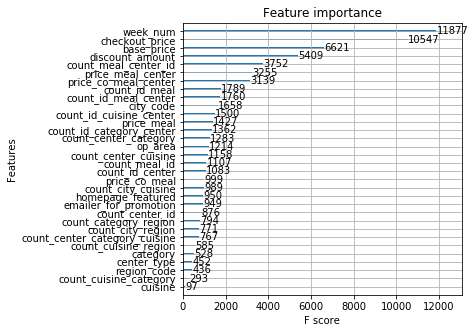

In [225]:
_,ax = plt.subplots(1,1,figsize=(5,5))
plot_importance(bst,ax)

In [179]:
gc.collect()

41

### Lightgbm

In [226]:
def train_lgb(max_depth=5,seed=4,num_round=2500):
    d_train = lgbm.Dataset(X,Y)
    #d_valid = lgbm.Dataset(X_valid, Y_valid)
    params = {
        'objective' :'regression',
        'max_depth':max_depth,
        'learning_rate' : 0.1,
        'num_leaves' :(2*max_depth)-1 ,
        'feature_fraction': 0.8,
        "min_data_in_leaf" : 100,
        'bagging_fraction': 0.7, 
        #'bagging_freq':1,
        'boosting_type' : 'gbdt',
        'metric': 'rmse',
        'seed':seed
    }
    lgb= lgbm.train(params, d_train, num_round)
    return lgb


In [227]:
lgb1=train_lgb(6,4,2500)
# lgb2=train_lgb(6,999,2500)
# pred = lgb1.predict(x_test)
# print(rmse(y_test,pred))

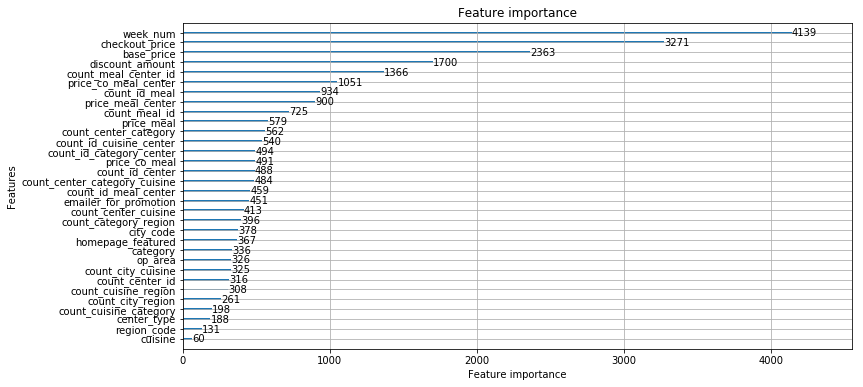

In [228]:
_,ax = plt.subplots(1,1,figsize=(12,6))
lgbm.plot_importance(lgb1,ax=ax)

## SUBMISSION

In [230]:
ddtest=xgb.DMatrix(test.drop(['id','week','center_id','meal_id'],axis=1))
pred=bst.predict(ddtest)#+bst1.predict(ddtest)+bst2.predict(ddtest)+bst3.predict(ddtest))/4
sub=pd.DataFrame()
sub['id']=test.id
sub['num_orders']=np.expm1(pred)
print(sub.shape)
sub.head()

(32573, 2)


,id,num_orders
0,1028232,135.382172
1,1127204,122.416481
2,1212707,129.429703
3,1082698,47.829472
4,1400926,34.885857


In [231]:
sub.to_csv('xgb-feature-xgb-10.csv',index=False)

In [232]:
temp=test.drop(['id','week','center_id','meal_id'],axis=1)
pred = lgb1.predict(temp)#+lgb2.predict(temp))/2
sub1=pd.DataFrame()
sub1['id']=test.id
sub1['num_orders']=np.expm1(pred)
sub1.head()

,id,num_orders
0,1028232,144.430810
1,1127204,145.814154
2,1212707,116.443550
3,1082698,38.040306
4,1400926,31.648292


In [233]:
# sub1.to_csv('lgb-5.csv',index=False)

In [235]:
sub2=sub.copy()
sub2.num_orders=0.6*sub.num_orders+sub1.num_orders*0.4
sub2.to_csv('ensemble-xgb-lgb-1.csv',index=False)
sub2.head()

,id,num_orders
0,1028232,139.001627
1,1127204,131.775550
2,1212707,124.235241
3,1082698,43.913805
4,1400926,33.590831
